In [103]:
%load_ext autoreload
%autoreload 2

In [104]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [105]:
movielens_dir = Path("./") / "datos-estructurados-itba-2020"

ratings_file = movielens_dir / "train.csv"
# ratings_file = movielens_dir / "train_data_expanded.csv"
# tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "item.csv"


df = pd.read_csv(ratings_file, sep='\t')
# tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file, sep='|')

Referencia: https://www.kaggle.com/code/faressayah/collaborative-filtering-for-movie-recommendations/notebook

In [106]:
print(movielens_dir)


datos-estructurados-itba-2020


In [107]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [108]:
df.describe()

,userId,movieId,rating,timestamp
count,80000.00000,80000.000000,80000.000000,8.000000e+04
mean,525.16570,425.705200,3.528350,8.835645e+08
std,255.94956,331.383936,1.118565,5.318611e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,334.00000,175.000000,3.000000,8.794556e+08
50%,535.00000,321.000000,4.000000,8.828441e+08
75%,744.00000,631.000000,4.000000,8.882676e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userId     80000 non-null  int64
 1   movieId    80000 non-null  int64
 2   rating     80000 non-null  int64
 3   timestamp  80000 non-null  int64
dtypes: int64(4)
memory usage: 2.4 MB


In [110]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 943, Number of Movies: 1650, Min Rating: 1.0, Max Rating: 5.0


In [111]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [112]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [113]:
EMBEDDING_SIZE = 50
# EMBEDDING_SIZE = 12

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
    # mac m1/m2 performance, use tf.keras.optimizers.legacy.Adam 
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.legacy.Adam(lr=0.001),
    metrics=[root_mean_squared_error,'mae', 'accuracy']
)

/Users/hordia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [114]:
# num_epochs = 200
# num_epochs = 100
num_epochs = 5

In [115]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=num_epochs,
#     verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/5


2023-08-20 21:53:04.328665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1122/1125 [============================>.] - ETA: 0s - loss: 0.6563 - root_mean_squared_error: 0.2776 - mae: 0.2309 - accuracy: 0.2024

2023-08-20 21:53:18.404233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1125/1125 [==============================] - 15s 13ms/step - loss: 0.6562 - root_mean_squared_error: 0.2776 - mae: 0.2309 - accuracy: 0.2023 - val_loss: 0.6407 - val_root_mean_squared_error: 0.2607 - val_mae: 0.2157 - val_accuracy: 0.2091
Epoch 2/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.6317 - root_mean_squared_error: 0.2564 - mae: 0.2103 - accuracy: 0.2190 - val_loss: 0.6358 - val_root_mean_squared_error: 0.2559 - val_mae: 0.2117 - val_accuracy: 0.2226
Epoch 3/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.6229 - root_mean_squared_error: 0.2484 - mae: 0.2013 - accuracy: 0.2277 - val_loss: 0.6279 - val_root_mean_squared_error: 0.2488 - val_mae: 0.2047 - val_accuracy: 0.2246
Epoch 4/5
1125/1125 [==============================] - 15s 13ms/step - loss: 0.6194 - root_mean_squared_error: 0.2454 - mae: 0.1974 - accuracy: 0.2309 - val_loss: 0.6260 - val_root_mean_squared_error: 0.2472 - val_mae: 0.2027 - val_accuracy: 0.2266
Epoch 5/5
1125

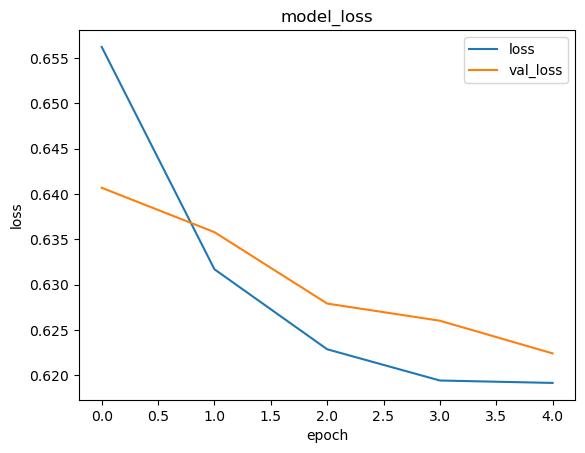

In [116]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [117]:
test_file = movielens_dir / "test.csv"

test_data = pd.read_csv(test_file, sep=',') # final test

In [118]:
idx_predicted = test_data[test_data['rating'] == 0].index
print(idx_predicted)

Index([   17,    20,    25,    26,    28,    29,    34,    36,    42,    44,
       ...
       19964, 19965, 19969, 19976, 19977, 19988, 19995, 19996, 19998, 19999],
      dtype='int64', length=4042)


In [119]:
def estimate_rates(user, movie):

    user_encoder = [[user]]
    movies_not_watched = [[movie]]

    user_movie_array = np.hstack(
        (user_encoder, movies_not_watched)
    )

    pred = model.predict(user_movie_array).flatten()[0]
    # print(user, movie)
    return pred

In [120]:
type(user2user_encoded)

dict

In [121]:
%%skip
# pruebas
a = np.array([356,5804])
print(a)

user_encoder = [[356],[351]]
movies_not_watched = [[5804], [23]]
user_encoder = [[356]]
movies_not_watched = [[5804]]

user_movie_array = np.hstack(
    (user_encoder, movies_not_watched)
)

model.predict(user_movie_array).flatten()[0]

UsageError: Cell magic `%%skip` not found.


probar con el train expandido para evitar clasificar con promedio usuarios o películas que no están en train
# ratings_file = movielens_dir / "train_data_expanded.csv"


In [122]:
import numpy as np

min_c=1 #mínima calificación posible
max_c=5 #máxima

# esto se tiene que poder resolver aplicando una función tipo lambda a test_data[test_data['rating'] == 0] 
# TODO: hacerlo más eficiente
for index, row in test_data.iterrows():
    # print(index, row['rating'])
    if row['rating']==0:
        print(index)
        # row['rating'] = 4 # predicted

        try:
            user = user2user_encoded[ row['userId'] ]
        except:
            #el usuario no existe en train
            # se asigna valor promedio
            print("No existe en el espacio latente, user: ", user)
            row['rating'] = 3 #valor promedio

        try:
            movie_item = movie2movie_encoded[ row['movieId'] ]
        except:
            #la película no existe en train
            # se asigna valor promedio
            print("No existe en el espacio latente, movie: ", user)
            row['rating'] = 3 #valor promedio

        prediction = estimate_rates(user,movie_item)
        # print(prediction)
        #warning si redondeo y da 0.3, deberia ser 1 que es el mínimo por eso también clippeo
        row['rating'] = np.clip( np.round(prediction),min_c,max_c) # redondeo porque los ratings son de 1 al 5 a

17
1/1 [==============================] - 0s 65ms/step
20
1/1 [==============================] - 0s 19ms/step


2023-08-20 21:54:19.224643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25
1/1 [==============================] - 0s 16ms/step
26
1/1 [==============================] - 0s 18ms/step
28
1/1 [==============================] - 0s 16ms/step
29
1/1 [==============================] - 0s 17ms/step
34
1/1 [==============================] - 0s 15ms/step
36
1/1 [==============================] - 0s 15ms/step
42
1/1 [==============================] - 0s 17ms/step
44
1/1 [==============================] - 0s 15ms/step
46
1/1 [==============================] - 0s 15ms/step
48
1/1 [==============================] - 0s 15ms/step
51
1/1 [==============================] - 0s 15ms/step
58
1/1 [==============================] - 0s 16ms/step
61
1/1 [==============================] - 0s 16ms/step
69
1/1 [==============================] - 0s 16ms/step
74
1/1 [==============================] - 0s 16ms/step
79
1/1 [==============================] - 0s 15ms/step
90
1/1 [==============================] - 0s 16ms/step
97
1/1 [==============================] - 0s 16ms/step
106
1/1 [=

188/188 [==============================] - 2s 12ms/step - loss: 0.9888 - root_mean_squared_error: 0.8409 - mae: 0.6650 - accuracy: 0.0583 - val_loss: 1.1854 - val_root_mean_squared_error: 0.9503 - val_mae: 0.7467 - val_accuracy: 0.0576

In [126]:
test_data[test_data['rating'] == 0]

,Id,userId,movieId,rating


In [127]:
test_data.to_csv('test-with-predicted-keras-v2.csv', index=False) # ya tiene una columna índice, no agregar otra

In [128]:
test_data

,Id,userId,movieId,rating
0,0,1,6,3
1,1,1,10,3
2,2,1,12,3
3,3,1,14,2
4,4,1,17,4
...,...,...,...,...
19995,19995,458,648,1
19996,19996,458,1101,1
19997,19997,459,934,2
19998,19998,460,10,1
